In [1]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    from google.colab import files
    files.upload()
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download \
    -d sixhky/open-images-bus-trucks/
    !unzip -qq open-images-bus-trucks.zip
    !rm open-images-bus-trucks.zip

     |████████████████████████████████| 43 kB 894 kB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 57 kB 4.8 MB/s 
     |████████████████████████████████| 213 kB 34.0 MB/s 
     |████████████████████████████████| 10.1 MB 39.0 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 


Saving kaggle.json to kaggle.json
kaggle.json
 98% 358M/367M [00:03<00:00, 151MB/s]
100% 367M/367M [00:03<00:00, 114MB/s]


In [24]:
from torch_snippets import *
from PIL import Image

IMAGE_ROOT = '/content/images/images'
DF_RAW = df = pd.read_csv('/content/df.csv')

DF_RAW = DF_RAW.sample(100)

DF_RAW.head(3)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
21477,e1fdc204047e8b7a,xclick,Truck,1,0.613125,0.786250,0.253333,0.353333,1,0,0,0,0,0.641875,0.786250,0.649375,0.613125,0.253333,0.335833,0.353333,0.310000
6991,416f2808e6774766,xclick,Bus,1,0.000000,0.698125,0.000000,0.999167,0,1,0,0,0,0.490625,0.000000,0.043750,0.698125,0.000000,0.335833,0.999167,0.828333
20594,d7bf628cc800c74a,xclick,Truck,1,0.353125,0.372500,0.734167,0.784167,1,0,0,0,0,0.368750,0.354375,0.372500,0.353125,0.734167,0.737500,0.761667,0.784167


In [58]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [59]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [60]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()

    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() 
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

In [62]:
from sklearn.model_selection import train_test_split

df = df.iloc[:200, :]

trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
print(len(trn_df), len(val_df))

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

180 20


In [63]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [64]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() 
def validate_batch(inputs, model):
    model.train() 
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [65]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 10
log = Report(n_epochs)

In [67]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        
    if (epoch+1)%(n_epochs//n_epochs)==0: 
        log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.317	trn_loc_loss: 0.140	trn_regr_loss: 0.142	trn_objectness_loss: 0.023	trn_rpn_box_reg_loss: 0.011	val_loss: 0.221	val_loc_loss: 0.082	val_regr_loss: 0.119	val_objectness_loss: 0.012	val_rpn_box_reg_loss: 0.008	(222.94s - 2006.45s remaining)
EPOCH: 2.000	trn_loss: 0.218	trn_loc_loss: 0.080	trn_regr_loss: 0.117	trn_objectness_loss: 0.011	trn_rpn_box_reg_loss: 0.010	val_loss: 0.194	val_loc_loss: 0.077	val_regr_loss: 0.102	val_objectness_loss: 0.009	val_rpn_box_reg_loss: 0.006	(283.83s - 1135.32s remaining)
EPOCH: 3.000	trn_loss: 0.160	trn_loc_loss: 0.052	trn_regr_loss: 0.094	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.011	val_loss: 0.224	val_loc_loss: 0.090	val_regr_loss: 0.120	val_objectness_loss: 0.008	val_rpn_box_reg_loss: 0.006	(344.55s - 803.96s remaining)
EPOCH: 4.000	trn_loss: 0.120	trn_loc_loss: 0.038	trn_regr_loss: 0.074	trn_objectness_loss: 0.002	trn_rpn_box_reg_loss: 0.006	val_loss: 0.195	val_loc_loss: 0.080	val_regr_loss: 0.103	val_objectness_

100%|██████████| 111/111 [00:00<00:00, 7214.86it/s]


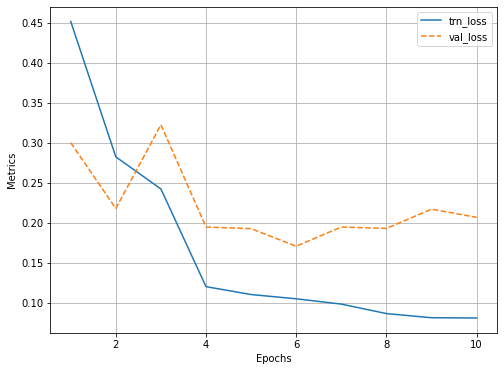

In [68]:
log.plot_epochs(['trn_loss','val_loss'])

In [69]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


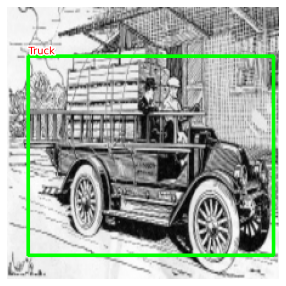

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


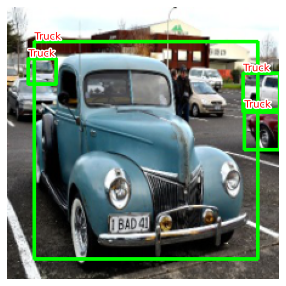

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


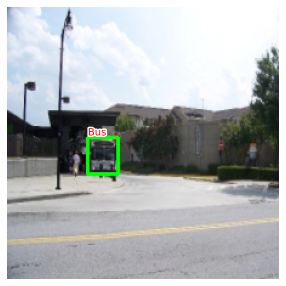

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


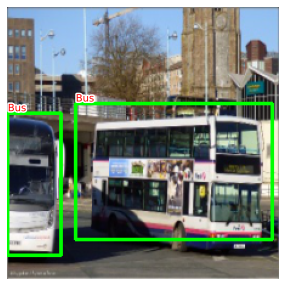

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


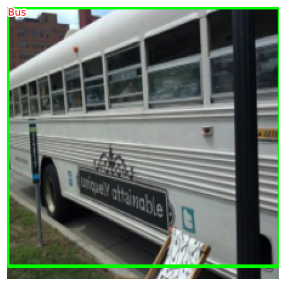

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


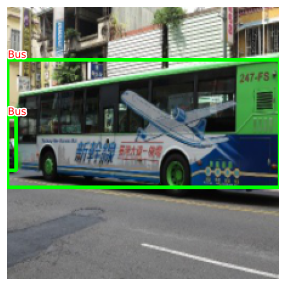

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


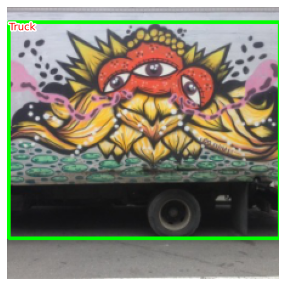

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


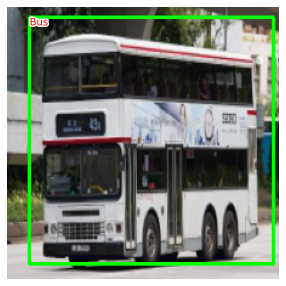

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


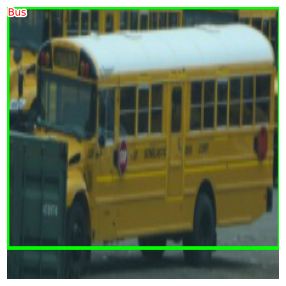

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


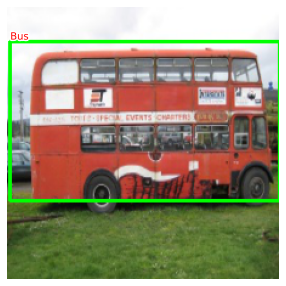

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


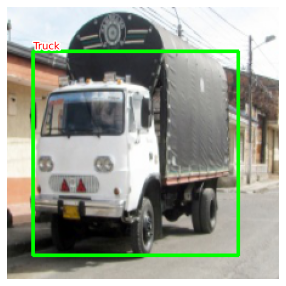

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


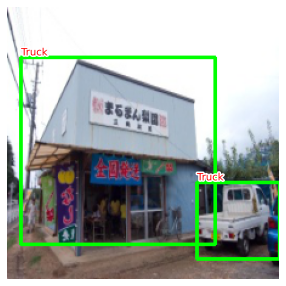

In [70]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)